## Run Algorithm 3 on stationary OU, with J imposed at middle and final time

In [4]:

import matplotlib.pyplot as plt
import numpy as np
import math


dim = 1
walkers = 500   # size of the interacting particle system
m = 50   # number of purturbations for FI estimator
sigma = 0.5   # size of perturbation


hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

# OU as reference: dXt = - beta X_t dt + sqrt{2}dW_t
# stationary distribution \nu is N(0,1/beta) with variance = 1/beta
beta = 0.25
X_init = np.random.normal(0,1/math.sqrt(beta),walkers)  # initialize walkers from Gaussian


grad_V = lambda x: beta*x   # gradient of reference potential
delta_log_nu = lambda x: -beta*dim   


# likelihood function: x(middle_point)=-3, x(final_point = 3). So J is 0 for most t.
# without J, one expect N(0,1/beta)
tol = 0.01


Train loss: 2855.74169921875
Train loss: 275.18963623046875
Train loss: 9.411462720265718e-09
Train loss: 0.0
Train loss: 0.0
Train loss: 0.0
Train loss: 0.06532914936542511
Train loss: 0.2348002940416336
Train loss: 0.011677110567688942
Train loss: 0.05196762830018997
Train loss: 0.03648897260427475
Train loss: 0.0
Train loss: 0.0
Train loss: 0.0
Train loss: 0.0
Train loss: 2.1168244757063803e-07
Train loss: 0.0
Train loss: 0.0
Train loss: 0.0
Train loss: 7.911466468613071e-07
Train loss: 8.992806499463768e-14
Train loss: 0.0
Train loss: 6.3871130606685256e-12
Train loss: 0.0
Train loss: 0.18687224388122559
Train loss: 15.867959976196289
Train loss: 0.0
Train loss: 0.0
Train loss: 0.0
Train loss: 0.0
Train loss: 2.087972402572632
Train loss: 0.0
Train loss: 0.0
Train loss: 0.0
Train loss: 5.3136138916015625
Train loss: 0.0
Train loss: 0.0
Train loss: 4.687198043029639e-07
Train loss: 9.331606776186163e-08
Train loss: 1.9314736476871985e-08
Train loss: 0.00019468918617349118
Train loss

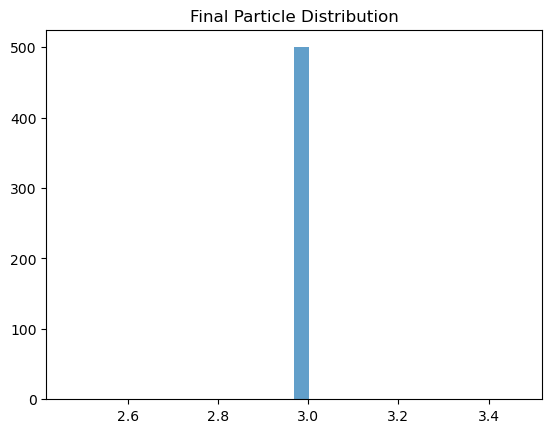

In [5]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import sys
sys.path.append("..")
from src.nn import MLP, train

key = jax.random.PRNGKey(0)

h = hyperparams['dt']
T = hyperparams['num_steps']*hyperparams['dt']
num_steps = hyperparams['num_steps']
num_training_steps = hyperparams['num_training_steps']

# Set up the neural network
mlp_dims = [3, 20, 20, 1]
model_key, key = jax.random.split(key)
phi = MLP(mlp_dims, key=model_key)
optimizer = optax.adam(1e-3)

choice_points = jnp.array([0.5, 1.0])
choice_location = jnp.array([-3.0, 3.0])


# Initialize particles
X_particles = jnp.array(X_init).reshape(-1, 1)  # shape (n, 1)

def L_theta(X, grad_V):
    # delta_log_nu(x) = -\beta
    return jnp.mean(jax.vmap(lambda x: 0.5 * jnp.linalg.norm(grad_V(x))**2 - beta )(X))


def R_theta(X, m, sigma, key):
    X = jnp.expand_dims(X, axis=0)
    n = X.shape[0]
    Y = X + sigma * jax.random.normal(key, (m, n))
    diff = Y - X
    return jnp.mean(jax.vmap(lambda k: jnp.linalg.norm(k)**2 / (2 * sigma ** 4))(diff))

def J_t(X,t):
    t_condition = jnp.any(t==choice_points)
    return t_condition * ((1/2.0)*(1/tol**2)*(X[0] - 3)**2)

def make_loss(rkey):
    def loss(phi, X, t, s):
        X_proposed = jax.vmap(jax.grad(lambda x: phi(x,  t, s)[0]))(X)
        term1 =  (1/(2*h**2)) * (jnp.mean(jax.vmap(lambda x,y: (x-y).dot(x-y))(X_proposed, X)))
        #term2 = jnp.mean(jax.vmap(lambda x: R_theta(x, m, sigma, rkey) + (2/h)*J_t(x, t))(X_proposed))
        term2 = jnp.mean(jax.vmap(lambda x: (2/h)*J_t(x, t))(X_proposed))
        term3 = L_theta(X_proposed, grad_V)
        return term1 + term2 #+ term3
    return loss


trajectories = []

# Main loop
for step in range(num_steps):
    t = step * h
    t_input = jnp.ones((1,)) * t
    s_input = jnp.ones((1,)) # a placeholder variable

    trajectories.append(X_particles)

    rkey = jax.random.fold_in(key, step)

    # new phi: but is it phi(\cdot, x)?
    phi = train(make_loss(rkey), phi, optimizer, num_training_steps, X_particles, jnp.ones((1,))*t, s_input)

    X_particles = jax.vmap(jax.grad(lambda x: phi(x,  t_input, s_input)[0]))(X_particles)


# After loop, X_particles contains the final samples
plt.hist(np.array(X_particles).flatten(), bins=30, alpha=0.7)
plt.title('Final Particle Distribution')
plt.show()

(100, 500)


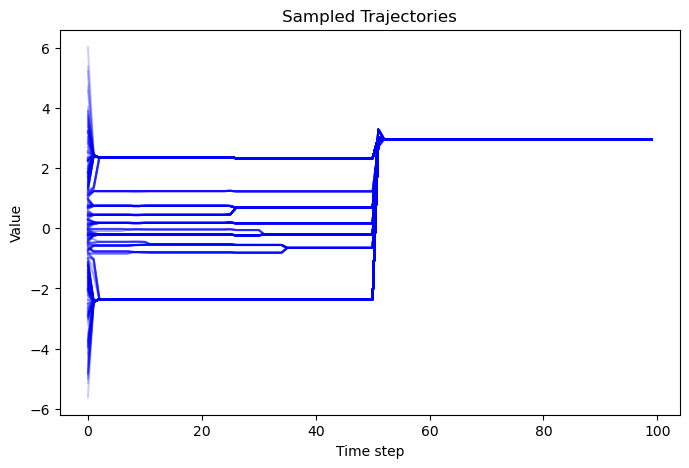

In [7]:


plotted_trajectories = jnp.array(trajectories)[:,:,-1]
print(plotted_trajectories.shape)


plt.figure(figsize=(8, 5))
for traj in plotted_trajectories.T:
    plt.plot(range(len(traj)), traj, color='blue', alpha=0.2)  # low alpha for overlap

plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Sampled Trajectories')
#plt.ylim([0, 1])
plt.show()